In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, SubsetRandomSampler, DataLoader, Dataset, Subset
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
torch.__version__

'2.5.1'

In [5]:
pl.__version__

'2.5.1.post0'

In [6]:
# Setting dataset path
path = "E:\\mini_ImageNet\\archive\\"

In [7]:
#Using the previously calculated values (first notebook) of mean and std of the images in this dataset
mean = [0.4764, 0.4491, 0.4001]
std = [0.2264, 0.2224, 0.2212]

print("Mean:", mean)
print("Std:", std)

Mean: [0.4764, 0.4491, 0.4001]
Std: [0.2264, 0.2224, 0.2212]


### Image Transforms

In [8]:
transform=transforms.Compose([
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    
        transforms.RandomRotation(20),      # rotate +/- 20 degrees
        transforms.RandomHorizontalFlip(p=0.25),  # flip 24% of images
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2)),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, 
                                                       saturation=0.2)], p=0.5), # jitters by +/- given value
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.7))], p=0.3)
    ])
#https://docs.pytorch.org/vision/main/transforms.html

In [9]:
#Getting class names from the folder names of images
class_names=sorted(os.listdir(path))
class_names = ['_'.join(c.split('_')[:-1]) for c in class_names]

### Data Module

In [10]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, batch_size:int=32, num_workers:int=10, transform=transform):
        super().__init__()
        # self.root_dir = "/kaggle/input/miniimagenet"
        self.root_dir = path
        self.transform = transform
        self.batch_size = batch_size
        self.num_w = num_workers

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.7 * n_data)
        n_valid = int(0.2 * n_data)
        n_test = n_data - n_train - n_valid
        
        self.train_dataset, self.val_dataset, self.test_dataset = torch.utils.data.random_split(dataset, [n_train, n_valid, n_test])
        
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, 
                  num_workers=self.num_w, persistent_workers=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, 
                  num_workers=self.num_w, persistent_workers=True)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, 
                  num_workers=self.num_w, persistent_workers=True)
        

### CNN Classifier

In [11]:
class ConvolutionalNetwork(pl.LightningModule):
    
    def __init__(self, class_labels, numChannels:int=3):
        super(ConvolutionalNetwork, self).__init__()
        
        #Initializing variable to collect grad norms 
        self._grad_norms = {}
        
        ##Initializing channel sizes for different layers
        
        self.conv1_out_channels = 16
        self.conv2_out_channels = 32
        self.conv3_out_channels = 64
        self.conv4_out_channels = 96
        
        self.fc1_out_features = 512
        self.fc2_out_features = 256
        self.fc3_out_features = 128
        self.fc4_out_features = len(class_labels)
        
        #Initializing lists to store train and val accuracies and losses
        self.training_accuracies = []
        self.validation_accuracies = []
        self.training_losses = []
        self.validation_losses = []


        #First conv layer block
        self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=self.conv1_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.conv1_out_channels)
        self.act1 = nn.LeakyReLU(0.05)          #also try leaky relu
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        #Second conv layer block
        self.conv2 = nn.Conv2d(in_channels=self.conv1_out_channels, out_channels=self.conv2_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(self.conv2_out_channels)
        self.act2 = nn.LeakyReLU(0.05)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        #Third conv layer block
        self.conv3 = nn.Conv2d(in_channels=self.conv2_out_channels, out_channels=self.conv3_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(self.conv3_out_channels)
        self.act3 = nn.LeakyReLU(0.05)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        #Fourth conv layer block
        self.conv4 = nn.Conv2d(in_channels=self.conv3_out_channels, out_channels=self.conv4_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(self.conv4_out_channels)
        self.act4 = nn.LeakyReLU(0.05)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        # Flatten
        self.flatten = nn.Flatten()
        
        #Fully connected layers
        self.fc1 = nn.LazyLinear(self.fc1_out_features)    #try bias=True ?
        self.dropout1 = nn.Dropout(0.5)
        self.act_fc1 = nn.LeakyReLU(0.05)
        
        self.fc2 = nn.Linear(in_features=self.fc1_out_features, out_features=self.fc2_out_features)
        self.dropout2 = nn.Dropout(0.3)
        self.act_fc2 = nn.LeakyReLU(0.05)
        
        self.fc3 = nn.Linear(in_features=self.fc2_out_features, out_features=self.fc3_out_features)
        self.dropout3 = nn.Dropout(0.3)
        self.act_fc3 = nn.LeakyReLU(0.05)
        
        self.fc4 = nn.Linear(in_features=self.fc3_out_features, out_features=self.fc4_out_features)
        self.output_activation  = nn.LogSoftmax(dim=1)
        
    # convolution output size formula: https://i.sstatic.net/vD1u3.png
    
    
    def forward(self, x):
        x = self.act1(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.act2(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.act3(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.act4(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        
        x = self.flatten(x)
        
        x = self.dropout1(self.act_fc1(self.fc1(x)))
        x = self.dropout2(self.act_fc2(self.fc2(x)))
        x = self.dropout3(self.act_fc2(self.fc3(x)))
        x = self.output_activation(self.fc4(x))
        
        return x

    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=1e-4)
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True),
            'monitor': 'val_loss'
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler}
    

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = (pred.squeeze() == y).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=False)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=False)
        return loss
    
    
    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = (pred.squeeze() == y).float().mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=False)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=False)
        

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)
        
        
    def on_train_epoch_end(self):
        train_acc = self.trainer.callback_metrics.get("train_acc")
        train_loss = self.trainer.callback_metrics.get("train_loss")
        if train_acc is not None:
            self.training_accuracies.append(train_acc.item())
        if train_loss is not None:
            self.training_losses.append(train_loss.item())
        print(f"\nTrain - After Epoch {self.current_epoch}: loss={train_loss:.3f}, acc={train_acc:.3f}")
        for param_group in self.trainer.optimizers[0].param_groups:
            print(f"Learning rate after epoch {self.current_epoch}: {param_group['lr']}")
        
        #Calculating average grad norms
        vanished_count = 0
        exploded_count = 0
        total_layers = len(self._grad_norms)

        for name, norms in self._grad_norms.items():
            avg_norm = sum(norms) / len(norms)

            # Log to TensorBoard
            self.logger.experiment.add_scalar(f"grad_norm_epoch_avg/{name}", avg_norm, self.current_epoch)

            # Stats
            if avg_norm < 1e-6:
                vanished_count += 1
            elif avg_norm > 100:
                exploded_count += 1

        # Log total stats
        self.log("grad_stats/total_layers", total_layers, on_epoch=True)
        self.log("grad_stats/vanished", vanished_count, on_epoch=True)
        self.log("grad_stats/exploded", exploded_count, on_epoch=True)

        print(f"[Epoch {self.current_epoch}] Grad Norms — Total: {total_layers}, Vanished: {vanished_count}, Exploded: {exploded_count}")

        # Reset buffer
        self._grad_norms.clear()
    

    def on_validation_epoch_end(self):
        val_loss = self.trainer.callback_metrics.get("val_loss")
        val_acc = self.trainer.callback_metrics.get("val_acc")
        if val_acc is not None:
            self.validation_accuracies.append(val_acc.item())
        if val_loss is not None:
            self.validation_losses.append(val_loss.item())
        print(f"\nVal - After Epoch {self.current_epoch}: loss={val_loss:.3f}, acc={val_acc:.3f}")
    
    
    def on_train_batch_end(self, outputs, batch, batch_idx, dataloader_idx=0):
        for name, param in self.named_parameters():
            if param.grad is not None:
                norm = param.grad.norm().item()
                if name not in self._grad_norms:
                    self._grad_norms[name] = []
                self._grad_norms[name].append(norm)


In [12]:
#Removing the Validation DataLoader progress bar between epochs
class MinimalProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        # Return a dummy tqdm with no visible output to disable validation progress bar
        # Set total=0 to avoid progress display
        return tqdm(disable=True)

    def init_test_tqdm(self):
        # Same for test dataloader
        return tqdm(disable=True)
    

In [13]:
#Setting seed to fetch the same training data every time
timestamp = datetime.now().strftime(format="%Y-%m-%d_%H-%M-%S")

In [14]:
#Configuring model checkpointing:
checkpoint_callback = ModelCheckpoint(
    dirpath=f"checkpoints\\{timestamp}",                   # Folder to save checkpoints
    filename=f"epoch{{epoch:02d}}-val_loss{{val_loss:.2f}}", 
    save_top_k=2,                             
    monitor="val_loss",                       # Metric to track best model
    mode="min",                               # Lower val_loss = better
    save_weights_only=False                  # Save full model
#     every_n_epochs=5                          # Save every 5 epochs
)

In [15]:
#Configuring early stopping callback
early_stop_callback = EarlyStopping(
    monitor="val_loss",     # or "val_acc", depending on your goal
    patience=9,             # number of epochs to wait with no improvement
    mode="min",             # "min" for loss, "max" for accuracy
    verbose=True
)

In [16]:
# Create logger
logger = TensorBoardLogger("tensorboard_logs", name="miniimagenet_cnn")

In [17]:
#Setting seed to fetch the same training data every time
pl.seed_everything(42, workers=True)  # `workers=True` ensures worker-level reproducibility

Seed set to 42


42

### Model Training

In [18]:
datamodule = DataModule(batch_size=128, num_workers=8)
datamodule.setup()
model = ConvolutionalNetwork(class_labels=class_names)
trainer = pl.Trainer(logger=logger,
                     callbacks=[MinimalProgressBar(), checkpoint_callback, early_stop_callback], 
                     default_root_dir="\\training_output", 
                     max_epochs=50)
trainer.fit(model, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\envs\torch_gpu_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\torch_gpu_env\lib\site-packages\pytorch_lightning\utilities\model_summary\model_summary.py:477: The total number of parameters detected may be inaccurate because the model contains an instance of `UninitializedParameter`. To get an accurate number, set `self.example_input_array` in your LightningModule.

   | Name              | Type        | Params | Mode 
-----------------------------------------------------------
0  | conv1             | Conv2d      | 448    | train
1  | bn1               | BatchNorm2d | 32     | train
2  | act1              | LeakyReLU   | 0      | train
3  | pool1     

Sanity Checking DataLoader 0: 100%|██████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.23it/s]
Val - After Epoch 0: loss=3.908, acc=0.031
Epoch 0: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:17<00:00,  2.12it/s, v_num=10]
Val - After Epoch 0: loss=3.617, acc=0.075
Epoch 0: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:39<00:00,  1.67it/s, v_num=10]

Metric val_loss improved. New best score: 3.617



Train - After Epoch 0: loss=3.785, acc=0.056
Learning rate after epoch 0: 0.001
[Epoch 0] Grad Norms — Total: 24, Vanished: 4, Exploded: 0
Epoch 1: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:11<00:00,  2.31it/s, v_num=10]
Val - After Epoch 1: loss=3.392, acc=0.112
Epoch 1: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:31<00:00,  1.80it/s, v_num=10]

Metric val_loss improved by 0.226 >= min_delta = 0.0. New best score: 3.392



Train - After Epoch 1: loss=3.555, acc=0.088
Learning rate after epoch 1: 0.001
[Epoch 1] Grad Norms — Total: 24, Vanished: 4, Exploded: 0
Epoch 2: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:13<00:00,  2.26it/s, v_num=10]
Val - After Epoch 2: loss=3.360, acc=0.134
Epoch 2: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:33<00:00,  1.76it/s, v_num=10]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 3.360



Train - After Epoch 2: loss=3.444, acc=0.112
Learning rate after epoch 2: 0.001
[Epoch 2] Grad Norms — Total: 24, Vanished: 4, Exploded: 0
Epoch 3: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.29it/s, v_num=10]
Val - After Epoch 3: loss=3.193, acc=0.161
Epoch 3: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:33<00:00,  1.77it/s, v_num=10]

Metric val_loss improved by 0.167 >= min_delta = 0.0. New best score: 3.193



Train - After Epoch 3: loss=3.371, acc=0.128
Learning rate after epoch 3: 0.001
[Epoch 3] Grad Norms — Total: 24, Vanished: 4, Exploded: 0
Epoch 4: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.28it/s, v_num=10]
Val - After Epoch 4: loss=3.172, acc=0.167
Epoch 4: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:33<00:00,  1.77it/s, v_num=10]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 3.172



Train - After Epoch 4: loss=3.313, acc=0.139
Learning rate after epoch 4: 0.001
[Epoch 4] Grad Norms — Total: 24, Vanished: 4, Exploded: 0
Epoch 5: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:14<00:00,  2.21it/s, v_num=10]
Val - After Epoch 5: loss=3.235, acc=0.150
Epoch 5: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:35<00:00,  1.73it/s, v_num=10]
Train - After Epoch 5: loss=3.255, acc=0.153
Learning rate after epoch 5: 0.001
[Epoch 5] Grad Norms — Total: 24, Vanished: 4, Exploded: 0
Epoch 6: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:13<00:00,  2.25it/s, v_num=10]
Val - After Epoch 6: loss=3.094, acc=0.182
Epoch 6: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:33<00:00,  1.76it/s, v_num=10]

Metric val_loss improved by 0.078 >= min_delta = 0.0. New best score: 3.094



Train - After Epoch 6: loss=3.199, acc=0.164
Learning rate after epoch 6: 0.001
[Epoch 6] Grad Norms — Total: 24, Vanished: 4, Exploded: 0
Epoch 7: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.27it/s, v_num=10]
Val - After Epoch 7: loss=3.030, acc=0.197
Epoch 7: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:33<00:00,  1.77it/s, v_num=10]

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 3.030



Train - After Epoch 7: loss=3.144, acc=0.179
Learning rate after epoch 7: 0.001
[Epoch 7] Grad Norms — Total: 24, Vanished: 4, Exploded: 0
Epoch 8: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.28it/s, v_num=10]
Val - After Epoch 8: loss=2.988, acc=0.214
Epoch 8: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:32<00:00,  1.79it/s, v_num=10]

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 2.988



Train - After Epoch 8: loss=3.086, acc=0.193
Learning rate after epoch 8: 0.001
[Epoch 8] Grad Norms — Total: 24, Vanished: 4, Exploded: 0
Epoch 9: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.28it/s, v_num=10]
Val - After Epoch 9: loss=3.044, acc=0.208
Epoch 9: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:32<00:00,  1.78it/s, v_num=10]
Train - After Epoch 9: loss=3.042, acc=0.200
Learning rate after epoch 9: 0.001
[Epoch 9] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 10: 100%|████████████████████████████████████████████████████████████| 165/165 [01:14<00:00,  2.23it/s, v_num=10]
Val - After Epoch 10: loss=2.939, acc=0.222
Epoch 10: 100%|████████████████████████████████████████████████████████████| 165/165 [01:34<00:00,  1.75it/s, v_num=10]

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 2.939



Train - After Epoch 10: loss=3.018, acc=0.211
Learning rate after epoch 10: 0.001
[Epoch 10] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 11: 100%|████████████████████████████████████████████████████████████| 165/165 [01:10<00:00,  2.32it/s, v_num=10]
Val - After Epoch 11: loss=2.912, acc=0.233
Epoch 11: 100%|████████████████████████████████████████████████████████████| 165/165 [01:30<00:00,  1.81it/s, v_num=10]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 2.912



Train - After Epoch 11: loss=2.957, acc=0.220
Learning rate after epoch 11: 0.001
[Epoch 11] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 12: 100%|████████████████████████████████████████████████████████████| 165/165 [01:10<00:00,  2.35it/s, v_num=10]
Val - After Epoch 12: loss=2.865, acc=0.251
Epoch 12: 100%|████████████████████████████████████████████████████████████| 165/165 [01:30<00:00,  1.82it/s, v_num=10]

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 2.865



Train - After Epoch 12: loss=2.933, acc=0.227
Learning rate after epoch 12: 0.001
[Epoch 12] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 13: 100%|████████████████████████████████████████████████████████████| 165/165 [01:13<00:00,  2.24it/s, v_num=10]
Val - After Epoch 13: loss=2.806, acc=0.261
Epoch 13: 100%|████████████████████████████████████████████████████████████| 165/165 [01:34<00:00,  1.75it/s, v_num=10]

Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 2.806



Train - After Epoch 13: loss=2.890, acc=0.237
Learning rate after epoch 13: 0.001
[Epoch 13] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 14: 100%|████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.29it/s, v_num=10]
Val - After Epoch 14: loss=2.764, acc=0.266
Epoch 14: 100%|████████████████████████████████████████████████████████████| 165/165 [01:32<00:00,  1.79it/s, v_num=10]

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 2.764



Train - After Epoch 14: loss=2.868, acc=0.239
Learning rate after epoch 14: 0.001
[Epoch 14] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 15: 100%|████████████████████████████████████████████████████████████| 165/165 [01:10<00:00,  2.32it/s, v_num=10]
Val - After Epoch 15: loss=2.799, acc=0.259
Epoch 15: 100%|████████████████████████████████████████████████████████████| 165/165 [01:31<00:00,  1.81it/s, v_num=10]
Train - After Epoch 15: loss=2.832, acc=0.250
Learning rate after epoch 15: 0.001
[Epoch 15] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 16: 100%|████████████████████████████████████████████████████████████| 165/165 [01:11<00:00,  2.31it/s, v_num=10]
Val - After Epoch 16: loss=3.083, acc=0.226
Epoch 16: 100%|████████████████████████████████████████████████████████████| 165/165 [01:32<00:00,  1.78it/s, v_num=10]
Train - After Epoch 16: loss=2.825, acc=0.251
Learning rate after epoch 16: 0.001
[Epoch 16] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch

Metric val_loss improved by 0.131 >= min_delta = 0.0. New best score: 2.633



Train - After Epoch 17: loss=2.773, acc=0.264
Learning rate after epoch 17: 0.001
[Epoch 17] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 18: 100%|████████████████████████████████████████████████████████████| 165/165 [01:10<00:00,  2.35it/s, v_num=10]
Val - After Epoch 18: loss=2.674, acc=0.284
Epoch 18: 100%|████████████████████████████████████████████████████████████| 165/165 [01:30<00:00,  1.82it/s, v_num=10]
Train - After Epoch 18: loss=2.750, acc=0.268
Learning rate after epoch 18: 0.001
[Epoch 18] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 19: 100%|████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.29it/s, v_num=10]
Val - After Epoch 19: loss=2.616, acc=0.300
Epoch 19: 100%|████████████████████████████████████████████████████████████| 165/165 [01:32<00:00,  1.79it/s, v_num=10]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 2.616



Train - After Epoch 19: loss=2.736, acc=0.270
Learning rate after epoch 19: 0.001
[Epoch 19] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 20: 100%|████████████████████████████████████████████████████████████| 165/165 [01:11<00:00,  2.31it/s, v_num=10]
Val - After Epoch 20: loss=2.605, acc=0.304
Epoch 20: 100%|████████████████████████████████████████████████████████████| 165/165 [01:31<00:00,  1.81it/s, v_num=10]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 2.605



Train - After Epoch 20: loss=2.695, acc=0.282
Learning rate after epoch 20: 0.001
[Epoch 20] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 21: 100%|████████████████████████████████████████████████████████████| 165/165 [01:11<00:00,  2.32it/s, v_num=10]
Val - After Epoch 21: loss=2.522, acc=0.317
Epoch 21: 100%|████████████████████████████████████████████████████████████| 165/165 [01:31<00:00,  1.81it/s, v_num=10]

Metric val_loss improved by 0.083 >= min_delta = 0.0. New best score: 2.522



Train - After Epoch 21: loss=2.661, acc=0.286
Learning rate after epoch 21: 0.001
[Epoch 21] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 22: 100%|████████████████████████████████████████████████████████████| 165/165 [01:11<00:00,  2.32it/s, v_num=10]
Val - After Epoch 22: loss=2.757, acc=0.278
Epoch 22: 100%|████████████████████████████████████████████████████████████| 165/165 [01:31<00:00,  1.81it/s, v_num=10]
Train - After Epoch 22: loss=2.643, acc=0.293
Learning rate after epoch 22: 0.001
[Epoch 22] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 23: 100%|████████████████████████████████████████████████████████████| 165/165 [01:11<00:00,  2.30it/s, v_num=10]
Val - After Epoch 23: loss=2.580, acc=0.315
Epoch 23: 100%|████████████████████████████████████████████████████████████| 165/165 [01:32<00:00,  1.78it/s, v_num=10]
Train - After Epoch 23: loss=2.629, acc=0.298
Learning rate after epoch 23: 0.001
[Epoch 23] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 2.484



Train - After Epoch 25: loss=2.617, acc=0.299
Learning rate after epoch 25: 0.001
[Epoch 25] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 26: 100%|████████████████████████████████████████████████████████████| 165/165 [01:13<00:00,  2.25it/s, v_num=10]
Val - After Epoch 26: loss=2.700, acc=0.292
Epoch 26: 100%|████████████████████████████████████████████████████████████| 165/165 [01:33<00:00,  1.76it/s, v_num=10]
Train - After Epoch 26: loss=2.581, acc=0.308
Learning rate after epoch 26: 0.001
[Epoch 26] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 27: 100%|████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.29it/s, v_num=10]
Val - After Epoch 27: loss=2.488, acc=0.328
Epoch 27: 100%|████████████████████████████████████████████████████████████| 165/165 [01:32<00:00,  1.79it/s, v_num=10]
Train - After Epoch 27: loss=2.563, acc=0.311
Learning rate after epoch 27: 0.001
[Epoch 27] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 2.479



Train - After Epoch 28: loss=2.565, acc=0.314
Learning rate after epoch 28: 0.001
[Epoch 28] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 29: 100%|████████████████████████████████████████████████████████████| 165/165 [01:11<00:00,  2.32it/s, v_num=10]
Val - After Epoch 29: loss=2.469, acc=0.338
Epoch 29: 100%|████████████████████████████████████████████████████████████| 165/165 [01:31<00:00,  1.81it/s, v_num=10]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 2.469



Train - After Epoch 29: loss=2.528, acc=0.320
Learning rate after epoch 29: 0.001
[Epoch 29] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 30: 100%|████████████████████████████████████████████████████████████| 165/165 [01:11<00:00,  2.30it/s, v_num=10]
Val - After Epoch 30: loss=2.402, acc=0.359
Epoch 30: 100%|████████████████████████████████████████████████████████████| 165/165 [01:32<00:00,  1.79it/s, v_num=10]

Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: 2.402



Train - After Epoch 30: loss=2.505, acc=0.322
Learning rate after epoch 30: 0.001
[Epoch 30] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 31: 100%|████████████████████████████████████████████████████████████| 165/165 [01:13<00:00,  2.25it/s, v_num=10]
Val - After Epoch 31: loss=2.413, acc=0.334
Epoch 31: 100%|████████████████████████████████████████████████████████████| 165/165 [01:33<00:00,  1.76it/s, v_num=10]
Train - After Epoch 31: loss=2.488, acc=0.328
Learning rate after epoch 31: 0.001
[Epoch 31] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 32: 100%|████████████████████████████████████████████████████████████| 165/165 [01:14<00:00,  2.20it/s, v_num=10]
Val - After Epoch 32: loss=2.505, acc=0.325
Epoch 32: 100%|████████████████████████████████████████████████████████████| 165/165 [01:35<00:00,  1.74it/s, v_num=10]
Train - After Epoch 32: loss=2.501, acc=0.326
Learning rate after epoch 32: 0.001
[Epoch 32] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch

Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 2.345



Train - After Epoch 33: loss=2.461, acc=0.334
Learning rate after epoch 33: 0.001
[Epoch 33] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 34: 100%|████████████████████████████████████████████████████████████| 165/165 [01:11<00:00,  2.30it/s, v_num=10]
Val - After Epoch 34: loss=2.436, acc=0.345
Epoch 34: 100%|████████████████████████████████████████████████████████████| 165/165 [01:31<00:00,  1.80it/s, v_num=10]
Train - After Epoch 34: loss=2.460, acc=0.334
Learning rate after epoch 34: 0.001
[Epoch 34] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 35: 100%|████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.27it/s, v_num=10]
Val - After Epoch 35: loss=2.337, acc=0.361
Epoch 35: 100%|████████████████████████████████████████████████████████████| 165/165 [01:32<00:00,  1.78it/s, v_num=10]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 2.337



Train - After Epoch 35: loss=2.461, acc=0.338
Learning rate after epoch 35: 0.001
[Epoch 35] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 36: 100%|████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.28it/s, v_num=10]
Val - After Epoch 36: loss=2.380, acc=0.357
Epoch 36: 100%|████████████████████████████████████████████████████████████| 165/165 [01:32<00:00,  1.79it/s, v_num=10]
Train - After Epoch 36: loss=2.436, acc=0.343
Learning rate after epoch 36: 0.001
[Epoch 36] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 37: 100%|████████████████████████████████████████████████████████████| 165/165 [01:11<00:00,  2.32it/s, v_num=10]
Val - After Epoch 37: loss=2.448, acc=0.344
Epoch 37: 100%|████████████████████████████████████████████████████████████| 165/165 [01:31<00:00,  1.81it/s, v_num=10]
Train - After Epoch 37: loss=2.433, acc=0.342
Learning rate after epoch 37: 0.001
[Epoch 37] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 2.313



Train - After Epoch 39: loss=2.390, acc=0.353
Learning rate after epoch 39: 0.001
[Epoch 39] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 40: 100%|████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.29it/s, v_num=10]
Val - After Epoch 40: loss=2.316, acc=0.374
Epoch 40: 100%|████████████████████████████████████████████████████████████| 165/165 [01:32<00:00,  1.79it/s, v_num=10]
Train - After Epoch 40: loss=2.370, acc=0.360
Learning rate after epoch 40: 0.001
[Epoch 40] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 41: 100%|████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.28it/s, v_num=10]
Val - After Epoch 41: loss=2.328, acc=0.370
Epoch 41: 100%|████████████████████████████████████████████████████████████| 165/165 [01:32<00:00,  1.78it/s, v_num=10]
Train - After Epoch 41: loss=2.371, acc=0.361
Learning rate after epoch 41: 0.001
[Epoch 41] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 2.277



Train - After Epoch 43: loss=2.339, acc=0.366
Learning rate after epoch 43: 0.001
[Epoch 43] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 44: 100%|████████████████████████████████████████████████████████████| 165/165 [01:11<00:00,  2.30it/s, v_num=10]
Val - After Epoch 44: loss=2.303, acc=0.387
Epoch 44: 100%|████████████████████████████████████████████████████████████| 165/165 [01:32<00:00,  1.79it/s, v_num=10]
Train - After Epoch 44: loss=2.334, acc=0.366
Learning rate after epoch 44: 0.001
[Epoch 44] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 45: 100%|████████████████████████████████████████████████████████████| 165/165 [01:11<00:00,  2.30it/s, v_num=10]
Val - After Epoch 45: loss=2.429, acc=0.367
Epoch 45: 100%|████████████████████████████████████████████████████████████| 165/165 [01:31<00:00,  1.80it/s, v_num=10]
Train - After Epoch 45: loss=2.324, acc=0.371
Learning rate after epoch 45: 0.001
[Epoch 45] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 2.226



Train - After Epoch 46: loss=2.342, acc=0.366
Learning rate after epoch 46: 0.001
[Epoch 46] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 47: 100%|████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.28it/s, v_num=10]
Val - After Epoch 47: loss=2.225, acc=0.388
Epoch 47: 100%|████████████████████████████████████████████████████████████| 165/165 [01:32<00:00,  1.78it/s, v_num=10]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 2.225



Train - After Epoch 47: loss=2.300, acc=0.375
Learning rate after epoch 47: 0.001
[Epoch 47] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 48: 100%|████████████████████████████████████████████████████████████| 165/165 [01:11<00:00,  2.31it/s, v_num=10]
Val - After Epoch 48: loss=2.241, acc=0.395
Epoch 48: 100%|████████████████████████████████████████████████████████████| 165/165 [01:31<00:00,  1.81it/s, v_num=10]
Train - After Epoch 48: loss=2.313, acc=0.372
Learning rate after epoch 48: 0.001
[Epoch 48] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 49: 100%|████████████████████████████████████████████████████████████| 165/165 [01:11<00:00,  2.31it/s, v_num=10]
Val - After Epoch 49: loss=2.325, acc=0.367
Epoch 49: 100%|████████████████████████████████████████████████████████████| 165/165 [01:32<00:00,  1.79it/s, v_num=10]

`Trainer.fit` stopped: `max_epochs=50` reached.



Train - After Epoch 49: loss=2.296, acc=0.373
Learning rate after epoch 49: 0.001
[Epoch 49] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 49: 100%|████████████████████████████████████████████████████████████| 165/165 [01:32<00:00,  1.79it/s, v_num=10]


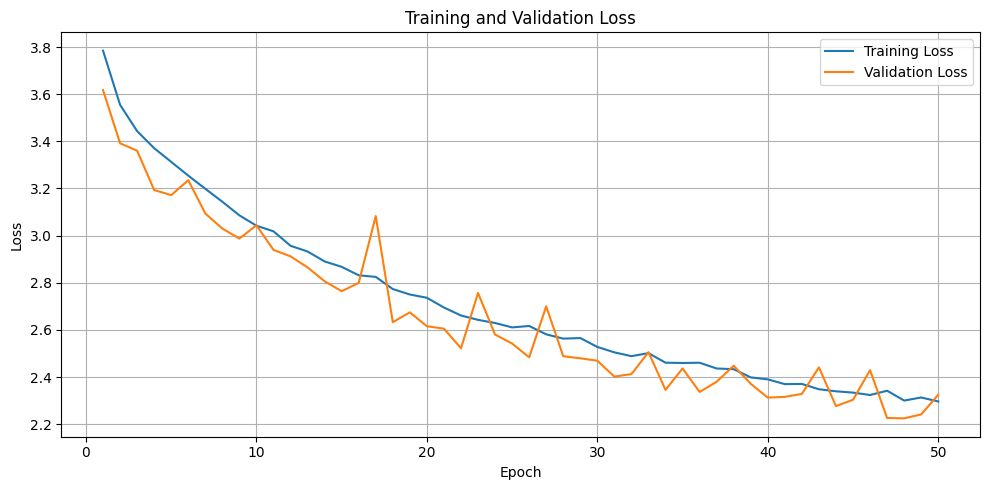

In [19]:
#Plotting train and validation loss
epochs = range(1, len(model.training_losses) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, model.training_losses, label='Training Loss')
plt.plot(epochs, model.validation_losses[1:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

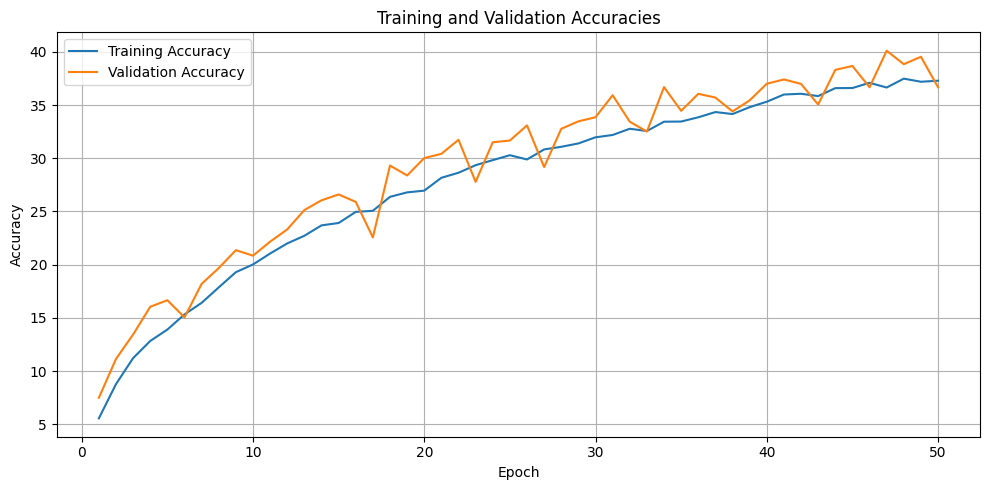

In [20]:
#Plotting train and validation accuracy
epochs = range(1, len(model.training_accuracies) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, [a*100 for a in model.training_accuracies], label='Training Accuracy')
plt.plot(epochs, [a*100 for a in model.validation_accuracies[1:]], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
#Training for another 50 epochs
trainer = pl.Trainer(logger=logger,
                     callbacks=[MinimalProgressBar(), checkpoint_callback, early_stop_callback], 
                     default_root_dir="\\training_output", 
                     max_epochs=100)
trainer.fit(model, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name              | Type        | Params | Mode 
-----------------------------------------------------------
0  | conv1             | Conv2d      | 448    | train
1  | bn1               | BatchNorm2d | 32     | train
2  | act1              | LeakyReLU   | 0      | train
3  | pool1             | MaxPool2d   | 0      | train
4  | conv2             | Conv2d      | 4.6 K  | train
5  | bn2               | BatchNorm2d | 64     | train
6  | act2              | LeakyReLU   | 0      | train
7  | pool2             | MaxPool2d   | 0      | train
8  | conv3             | Conv2d      | 18.5 K | train
9  | bn3               | BatchNorm2d | 128    | train
10 | act3              | LeakyReLU   | 0      | train
11 | pool3             | MaxPool2d   | 0      | train
12 | conv4             | Conv2d      | 55.4 K | train
13 | bn4               | 

Sanity Checking DataLoader 0: 100%|██████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.39it/s]
Val - After Epoch 0: loss=2.150, acc=0.434
Epoch 0: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:15<00:00,  2.18it/s, v_num=10]
Val - After Epoch 0: loss=2.175, acc=0.408
Epoch 0: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:37<00:00,  1.70it/s, v_num=10]

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 2.175



Train - After Epoch 0: loss=2.314, acc=0.370
Learning rate after epoch 0: 0.001
[Epoch 0] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 1: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:15<00:00,  2.18it/s, v_num=10]
Val - After Epoch 1: loss=2.184, acc=0.403
Epoch 1: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:37<00:00,  1.70it/s, v_num=10]
Train - After Epoch 1: loss=2.300, acc=0.376
Learning rate after epoch 1: 0.001
[Epoch 1] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 2: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:13<00:00,  2.25it/s, v_num=10]
Val - After Epoch 2: loss=2.173, acc=0.398
Epoch 2: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:34<00:00,  1.74it/s, v_num=10]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 2.173



Train - After Epoch 2: loss=2.280, acc=0.378
Learning rate after epoch 2: 0.001
[Epoch 2] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 3: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:13<00:00,  2.23it/s, v_num=10]
Val - After Epoch 3: loss=2.055, acc=0.440
Epoch 3: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:35<00:00,  1.73it/s, v_num=10]

Metric val_loss improved by 0.118 >= min_delta = 0.0. New best score: 2.055



Train - After Epoch 3: loss=2.279, acc=0.380
Learning rate after epoch 3: 0.001
[Epoch 3] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 4: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:14<00:00,  2.21it/s, v_num=10]
Val - After Epoch 4: loss=2.145, acc=0.417
Epoch 4: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:36<00:00,  1.71it/s, v_num=10]
Train - After Epoch 4: loss=2.248, acc=0.388
Learning rate after epoch 4: 0.001
[Epoch 4] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 5: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:15<00:00,  2.18it/s, v_num=10]
Val - After Epoch 5: loss=2.119, acc=0.418
Epoch 5: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:37<00:00,  1.70it/s, v_num=10]
Train - After Epoch 5: loss=2.245, acc=0.388
Learning rate after epoch 5: 0.001
[Epoch 5] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 6: 100%|██

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 2.028



Train - After Epoch 8: loss=2.168, acc=0.405
Learning rate after epoch 8: 0.0005
[Epoch 8] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 9: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:10<00:00,  2.34it/s, v_num=10]
Val - After Epoch 9: loss=2.049, acc=0.432
Epoch 9: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:30<00:00,  1.81it/s, v_num=10]
Train - After Epoch 9: loss=2.145, acc=0.411
Learning rate after epoch 9: 0.0005
[Epoch 9] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 10: 100%|████████████████████████████████████████████████████████████| 165/165 [01:13<00:00,  2.25it/s, v_num=10]
Val - After Epoch 10: loss=1.987, acc=0.460
Epoch 10: 100%|████████████████████████████████████████████████████████████| 165/165 [01:34<00:00,  1.75it/s, v_num=10]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.987



Train - After Epoch 10: loss=2.106, acc=0.424
Learning rate after epoch 10: 0.0005
[Epoch 10] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 11: 100%|████████████████████████████████████████████████████████████| 165/165 [01:11<00:00,  2.31it/s, v_num=10]
Val - After Epoch 11: loss=1.976, acc=0.453
Epoch 11: 100%|████████████████████████████████████████████████████████████| 165/165 [01:31<00:00,  1.80it/s, v_num=10]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.976



Train - After Epoch 11: loss=2.109, acc=0.418
Learning rate after epoch 11: 0.0005
[Epoch 11] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 12: 100%|████████████████████████████████████████████████████████████| 165/165 [01:15<00:00,  2.18it/s, v_num=10]
Val - After Epoch 12: loss=1.954, acc=0.458
Epoch 12: 100%|████████████████████████████████████████████████████████████| 165/165 [01:37<00:00,  1.70it/s, v_num=10]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.954



Train - After Epoch 12: loss=2.092, acc=0.425
Learning rate after epoch 12: 0.0005
[Epoch 12] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 13: 100%|████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.28it/s, v_num=10]
Val - After Epoch 13: loss=2.013, acc=0.451
Epoch 13: 100%|████████████████████████████████████████████████████████████| 165/165 [01:33<00:00,  1.77it/s, v_num=10]
Train - After Epoch 13: loss=2.078, acc=0.425
Learning rate after epoch 13: 0.0005
[Epoch 13] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 14: 100%|████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.27it/s, v_num=10]
Val - After Epoch 14: loss=1.995, acc=0.454
Epoch 14: 100%|████████████████████████████████████████████████████████████| 165/165 [01:33<00:00,  1.76it/s, v_num=10]
Train - After Epoch 14: loss=2.044, acc=0.436
Learning rate after epoch 14: 0.0005
[Epoch 14] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Ep

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 1.913



Train - After Epoch 17: loss=2.008, acc=0.449
Learning rate after epoch 17: 0.00025
[Epoch 17] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 18: 100%|████████████████████████████████████████████████████████████| 165/165 [01:10<00:00,  2.33it/s, v_num=10]
Val - After Epoch 18: loss=1.902, acc=0.472
Epoch 18: 100%|████████████████████████████████████████████████████████████| 165/165 [01:30<00:00,  1.81it/s, v_num=10]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.902



Train - After Epoch 18: loss=1.984, acc=0.450
Learning rate after epoch 18: 0.00025
[Epoch 18] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 19: 100%|████████████████████████████████████████████████████████████| 165/165 [01:09<00:00,  2.37it/s, v_num=10]
Val - After Epoch 19: loss=1.888, acc=0.479
Epoch 19: 100%|████████████████████████████████████████████████████████████| 165/165 [01:29<00:00,  1.84it/s, v_num=10]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.888



Train - After Epoch 19: loss=1.976, acc=0.452
Learning rate after epoch 19: 0.00025
[Epoch 19] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 20: 100%|████████████████████████████████████████████████████████████| 165/165 [01:09<00:00,  2.38it/s, v_num=10]
Val - After Epoch 20: loss=1.884, acc=0.472
Epoch 20: 100%|████████████████████████████████████████████████████████████| 165/165 [01:31<00:00,  1.81it/s, v_num=10]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.884



Train - After Epoch 20: loss=1.964, acc=0.455
Learning rate after epoch 20: 0.00025
[Epoch 20] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 21: 100%|████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.28it/s, v_num=10]
Val - After Epoch 21: loss=1.877, acc=0.484
Epoch 21: 100%|████████████████████████████████████████████████████████████| 165/165 [01:33<00:00,  1.77it/s, v_num=10]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.877



Train - After Epoch 21: loss=1.955, acc=0.460
Learning rate after epoch 21: 0.00025
[Epoch 21] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 22: 100%|████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.27it/s, v_num=10]
Val - After Epoch 22: loss=1.899, acc=0.474
Epoch 22: 100%|████████████████████████████████████████████████████████████| 165/165 [01:34<00:00,  1.75it/s, v_num=10]
Train - After Epoch 22: loss=1.959, acc=0.459
Learning rate after epoch 22: 0.00025
[Epoch 22] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 23: 100%|████████████████████████████████████████████████████████████| 165/165 [01:10<00:00,  2.32it/s, v_num=10]
Val - After Epoch 23: loss=1.882, acc=0.474
Epoch 23: 100%|████████████████████████████████████████████████████████████| 165/165 [01:31<00:00,  1.80it/s, v_num=10]
Train - After Epoch 23: loss=1.944, acc=0.461
Learning rate after epoch 23: 0.00025
[Epoch 23] Grad Norms — Total: 24, Vanished: 3, Exploded: 0

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.869



Train - After Epoch 25: loss=1.926, acc=0.465
Learning rate after epoch 25: 0.00025
[Epoch 25] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 26: 100%|████████████████████████████████████████████████████████████| 165/165 [01:13<00:00,  2.25it/s, v_num=10]
Val - After Epoch 26: loss=1.877, acc=0.491
Epoch 26: 100%|████████████████████████████████████████████████████████████| 165/165 [01:34<00:00,  1.75it/s, v_num=10]
Train - After Epoch 26: loss=1.933, acc=0.468
Learning rate after epoch 26: 0.00025
[Epoch 26] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 27: 100%|████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.29it/s, v_num=10]
Val - After Epoch 27: loss=1.880, acc=0.481
Epoch 27: 100%|████████████████████████████████████████████████████████████| 165/165 [01:32<00:00,  1.78it/s, v_num=10]
Train - After Epoch 27: loss=1.931, acc=0.464
Learning rate after epoch 27: 0.00025
[Epoch 27] Grad Norms — Total: 24, Vanished: 3, Exploded: 0

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.867



Train - After Epoch 28: loss=1.916, acc=0.472
Learning rate after epoch 28: 0.00025
[Epoch 28] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 29: 100%|████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.26it/s, v_num=10]
Val - After Epoch 29: loss=1.905, acc=0.481
Epoch 29: 100%|████████████████████████████████████████████████████████████| 165/165 [01:34<00:00,  1.75it/s, v_num=10]
Train - After Epoch 29: loss=1.907, acc=0.471
Learning rate after epoch 29: 0.00025
[Epoch 29] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 30: 100%|████████████████████████████████████████████████████████████| 165/165 [01:11<00:00,  2.31it/s, v_num=10]
Val - After Epoch 30: loss=1.864, acc=0.492
Epoch 30: 100%|████████████████████████████████████████████████████████████| 165/165 [01:31<00:00,  1.80it/s, v_num=10]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.864



Train - After Epoch 30: loss=1.902, acc=0.470
Learning rate after epoch 30: 0.00025
[Epoch 30] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 31: 100%|████████████████████████████████████████████████████████████| 165/165 [01:14<00:00,  2.22it/s, v_num=10]
Val - After Epoch 31: loss=1.873, acc=0.481
Epoch 31: 100%|████████████████████████████████████████████████████████████| 165/165 [01:35<00:00,  1.74it/s, v_num=10]
Train - After Epoch 31: loss=1.901, acc=0.478
Learning rate after epoch 31: 0.00025
[Epoch 31] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 32: 100%|████████████████████████████████████████████████████████████| 165/165 [01:11<00:00,  2.31it/s, v_num=10]
Val - After Epoch 32: loss=1.862, acc=0.480
Epoch 32: 100%|████████████████████████████████████████████████████████████| 165/165 [01:31<00:00,  1.80it/s, v_num=10]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.862



Train - After Epoch 32: loss=1.894, acc=0.472
Learning rate after epoch 32: 0.00025
[Epoch 32] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 33: 100%|████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.28it/s, v_num=10]
Val - After Epoch 33: loss=1.852, acc=0.489
Epoch 33: 100%|████████████████████████████████████████████████████████████| 165/165 [01:33<00:00,  1.76it/s, v_num=10]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.852



Train - After Epoch 33: loss=1.882, acc=0.475
Learning rate after epoch 33: 0.00025
[Epoch 33] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 34: 100%|████████████████████████████████████████████████████████████| 165/165 [01:10<00:00,  2.34it/s, v_num=10]
Val - After Epoch 34: loss=1.857, acc=0.489
Epoch 34: 100%|████████████████████████████████████████████████████████████| 165/165 [01:30<00:00,  1.82it/s, v_num=10]
Train - After Epoch 34: loss=1.880, acc=0.473
Learning rate after epoch 34: 0.00025
[Epoch 34] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 35: 100%|████████████████████████████████████████████████████████████| 165/165 [01:10<00:00,  2.33it/s, v_num=10]
Val - After Epoch 35: loss=1.861, acc=0.486
Epoch 35: 100%|████████████████████████████████████████████████████████████| 165/165 [01:30<00:00,  1.81it/s, v_num=10]
Train - After Epoch 35: loss=1.871, acc=0.484
Learning rate after epoch 35: 0.00025
[Epoch 35] Grad Norms — Total: 24, Vanished: 3, Exploded: 0

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.844



Train - After Epoch 36: loss=1.884, acc=0.476
Learning rate after epoch 36: 0.00025
[Epoch 36] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 37: 100%|████████████████████████████████████████████████████████████| 165/165 [01:10<00:00,  2.34it/s, v_num=10]
Val - After Epoch 37: loss=1.842, acc=0.499
Epoch 37: 100%|████████████████████████████████████████████████████████████| 165/165 [01:30<00:00,  1.82it/s, v_num=10]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.842



Train - After Epoch 37: loss=1.863, acc=0.482
Learning rate after epoch 37: 0.00025
[Epoch 37] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 38: 100%|████████████████████████████████████████████████████████████| 165/165 [01:09<00:00,  2.36it/s, v_num=10]
Val - After Epoch 38: loss=1.833, acc=0.493
Epoch 38: 100%|████████████████████████████████████████████████████████████| 165/165 [01:30<00:00,  1.83it/s, v_num=10]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.833



Train - After Epoch 38: loss=1.864, acc=0.485
Learning rate after epoch 38: 0.00025
[Epoch 38] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 39: 100%|████████████████████████████████████████████████████████████| 165/165 [01:11<00:00,  2.31it/s, v_num=10]
Val - After Epoch 39: loss=1.836, acc=0.490
Epoch 39: 100%|████████████████████████████████████████████████████████████| 165/165 [01:31<00:00,  1.80it/s, v_num=10]
Train - After Epoch 39: loss=1.861, acc=0.484
Learning rate after epoch 39: 0.00025
[Epoch 39] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 40: 100%|████████████████████████████████████████████████████████████| 165/165 [01:10<00:00,  2.33it/s, v_num=10]
Val - After Epoch 40: loss=1.830, acc=0.490
Epoch 40: 100%|████████████████████████████████████████████████████████████| 165/165 [01:31<00:00,  1.81it/s, v_num=10]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.830



Train - After Epoch 40: loss=1.857, acc=0.483
Learning rate after epoch 40: 0.00025
[Epoch 40] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 41: 100%|████████████████████████████████████████████████████████████| 165/165 [01:10<00:00,  2.35it/s, v_num=10]
Val - After Epoch 41: loss=1.833, acc=0.490
Epoch 41: 100%|████████████████████████████████████████████████████████████| 165/165 [01:30<00:00,  1.83it/s, v_num=10]
Train - After Epoch 41: loss=1.848, acc=0.483
Learning rate after epoch 41: 0.00025
[Epoch 41] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 42: 100%|████████████████████████████████████████████████████████████| 165/165 [01:10<00:00,  2.35it/s, v_num=10]
Val - After Epoch 42: loss=1.852, acc=0.495
Epoch 42: 100%|████████████████████████████████████████████████████████████| 165/165 [01:30<00:00,  1.83it/s, v_num=10]
Train - After Epoch 42: loss=1.834, acc=0.489
Learning rate after epoch 42: 0.00025
[Epoch 42] Grad Norms — Total: 24, Vanished: 3, Exploded: 0

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 1.800



Train - After Epoch 45: loss=1.816, acc=0.492
Learning rate after epoch 45: 0.000125
[Epoch 45] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 46: 100%|████████████████████████████████████████████████████████████| 165/165 [01:11<00:00,  2.30it/s, v_num=10]
Val - After Epoch 46: loss=1.816, acc=0.500
Epoch 46: 100%|████████████████████████████████████████████████████████████| 165/165 [01:32<00:00,  1.79it/s, v_num=10]
Train - After Epoch 46: loss=1.815, acc=0.494
Learning rate after epoch 46: 0.000125
[Epoch 46] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 47: 100%|████████████████████████████████████████████████████████████| 165/165 [01:10<00:00,  2.35it/s, v_num=10]
Val - After Epoch 47: loss=1.792, acc=0.501
Epoch 47: 100%|████████████████████████████████████████████████████████████| 165/165 [01:30<00:00,  1.82it/s, v_num=10]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.792



Train - After Epoch 47: loss=1.793, acc=0.500
Learning rate after epoch 47: 0.000125
[Epoch 47] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 48: 100%|████████████████████████████████████████████████████████████| 165/165 [01:10<00:00,  2.35it/s, v_num=10]
Val - After Epoch 48: loss=1.798, acc=0.500
Epoch 48: 100%|████████████████████████████████████████████████████████████| 165/165 [01:30<00:00,  1.82it/s, v_num=10]
Train - After Epoch 48: loss=1.795, acc=0.501
Learning rate after epoch 48: 0.000125
[Epoch 48] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 49: 100%|████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.27it/s, v_num=10]
Val - After Epoch 49: loss=1.796, acc=0.511
Epoch 49: 100%|████████████████████████████████████████████████████████████| 165/165 [01:34<00:00,  1.75it/s, v_num=10]
Train - After Epoch 49: loss=1.795, acc=0.499
Learning rate after epoch 49: 0.000125
[Epoch 49] Grad Norms — Total: 24, Vanished: 3, Exploded

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.786



Train - After Epoch 51: loss=1.785, acc=0.502
Learning rate after epoch 51: 0.000125
[Epoch 51] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 52: 100%|████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.26it/s, v_num=10]
Val - After Epoch 52: loss=1.794, acc=0.501
Epoch 52: 100%|████████████████████████████████████████████████████████████| 165/165 [01:33<00:00,  1.76it/s, v_num=10]
Train - After Epoch 52: loss=1.777, acc=0.507
Learning rate after epoch 52: 0.000125
[Epoch 52] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 53: 100%|████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.28it/s, v_num=10]
Val - After Epoch 53: loss=1.785, acc=0.509
Epoch 53: 100%|████████████████████████████████████████████████████████████| 165/165 [01:32<00:00,  1.78it/s, v_num=10]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.785



Train - After Epoch 53: loss=1.780, acc=0.504
Learning rate after epoch 53: 0.000125
[Epoch 53] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 54: 100%|████████████████████████████████████████████████████████████| 165/165 [01:10<00:00,  2.34it/s, v_num=10]
Val - After Epoch 54: loss=1.794, acc=0.506
Epoch 54: 100%|████████████████████████████████████████████████████████████| 165/165 [01:30<00:00,  1.82it/s, v_num=10]
Train - After Epoch 54: loss=1.776, acc=0.503
Learning rate after epoch 54: 0.000125
[Epoch 54] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 55: 100%|████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.29it/s, v_num=10]
Val - After Epoch 55: loss=1.785, acc=0.507
Epoch 55: 100%|████████████████████████████████████████████████████████████| 165/165 [01:33<00:00,  1.76it/s, v_num=10]
Train - After Epoch 55: loss=1.770, acc=0.509
Learning rate after epoch 55: 0.000125
[Epoch 55] Grad Norms — Total: 24, Vanished: 3, Exploded

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.772



Train - After Epoch 56: loss=1.765, acc=0.508
Learning rate after epoch 56: 0.000125
[Epoch 56] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 57: 100%|████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.28it/s, v_num=10]
Val - After Epoch 57: loss=1.794, acc=0.505
Epoch 57: 100%|████████████████████████████████████████████████████████████| 165/165 [01:32<00:00,  1.78it/s, v_num=10]
Train - After Epoch 57: loss=1.775, acc=0.505
Learning rate after epoch 57: 0.000125
[Epoch 57] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 58: 100%|████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.27it/s, v_num=10]
Val - After Epoch 58: loss=1.788, acc=0.504
Epoch 58: 100%|████████████████████████████████████████████████████████████| 165/165 [01:33<00:00,  1.76it/s, v_num=10]
Train - After Epoch 58: loss=1.744, acc=0.513
Learning rate after epoch 58: 0.000125
[Epoch 58] Grad Norms — Total: 24, Vanished: 3, Exploded

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.767



Train - After Epoch 60: loss=1.760, acc=0.510
Learning rate after epoch 60: 0.000125
[Epoch 60] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 61: 100%|████████████████████████████████████████████████████████████| 165/165 [01:11<00:00,  2.30it/s, v_num=10]
Val - After Epoch 61: loss=1.784, acc=0.510
Epoch 61: 100%|████████████████████████████████████████████████████████████| 165/165 [01:32<00:00,  1.79it/s, v_num=10]
Train - After Epoch 61: loss=1.750, acc=0.510
Learning rate after epoch 61: 0.000125
[Epoch 61] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 62: 100%|████████████████████████████████████████████████████████████| 165/165 [01:11<00:00,  2.32it/s, v_num=10]
Val - After Epoch 62: loss=1.792, acc=0.507
Epoch 62: 100%|████████████████████████████████████████████████████████████| 165/165 [01:31<00:00,  1.81it/s, v_num=10]
Train - After Epoch 62: loss=1.744, acc=0.512
Learning rate after epoch 62: 0.000125
[Epoch 62] Grad Norms — Total: 24, Vanished: 3, Exploded

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.763



Train - After Epoch 65: loss=1.728, acc=0.514
Learning rate after epoch 65: 6.25e-05
[Epoch 65] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 66: 100%|████████████████████████████████████████████████████████████| 165/165 [01:09<00:00,  2.38it/s, v_num=10]
Val - After Epoch 66: loss=1.744, acc=0.518
Epoch 66: 100%|████████████████████████████████████████████████████████████| 165/165 [01:29<00:00,  1.84it/s, v_num=10]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.744



Train - After Epoch 66: loss=1.732, acc=0.513
Learning rate after epoch 66: 6.25e-05
[Epoch 66] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 67: 100%|████████████████████████████████████████████████████████████| 165/165 [01:10<00:00,  2.35it/s, v_num=10]
Val - After Epoch 67: loss=1.754, acc=0.510
Epoch 67: 100%|████████████████████████████████████████████████████████████| 165/165 [01:30<00:00,  1.82it/s, v_num=10]
Train - After Epoch 67: loss=1.718, acc=0.518
Learning rate after epoch 67: 6.25e-05
[Epoch 67] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 68: 100%|████████████████████████████████████████████████████████████| 165/165 [01:10<00:00,  2.34it/s, v_num=10]
Val - After Epoch 68: loss=1.763, acc=0.509
Epoch 68: 100%|████████████████████████████████████████████████████████████| 165/165 [01:31<00:00,  1.81it/s, v_num=10]
Train - After Epoch 68: loss=1.719, acc=0.518
Learning rate after epoch 68: 6.25e-05
[Epoch 68] Grad Norms — Total: 24, Vanished: 3, Exploded

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.737



Train - After Epoch 74: loss=1.702, acc=0.523
Learning rate after epoch 74: 3.125e-05
[Epoch 74] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 75: 100%|████████████████████████████████████████████████████████████| 165/165 [01:10<00:00,  2.33it/s, v_num=10]
Val - After Epoch 75: loss=1.739, acc=0.524
Epoch 75: 100%|████████████████████████████████████████████████████████████| 165/165 [01:31<00:00,  1.80it/s, v_num=10]
Train - After Epoch 75: loss=1.695, acc=0.525
Learning rate after epoch 75: 3.125e-05
[Epoch 75] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 76: 100%|████████████████████████████████████████████████████████████| 165/165 [01:11<00:00,  2.31it/s, v_num=10]
Val - After Epoch 76: loss=1.758, acc=0.512
Epoch 76: 100%|████████████████████████████████████████████████████████████| 165/165 [01:31<00:00,  1.80it/s, v_num=10]
Train - After Epoch 76: loss=1.684, acc=0.526
Learning rate after epoch 76: 3.125e-05
[Epoch 76] Grad Norms — Total: 24, Vanished: 3, Explo

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.728



Train - After Epoch 78: loss=1.697, acc=0.522
Learning rate after epoch 78: 3.125e-05
[Epoch 78] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 79: 100%|████████████████████████████████████████████████████████████| 165/165 [01:10<00:00,  2.35it/s, v_num=10]
Val - After Epoch 79: loss=1.755, acc=0.511
Epoch 79: 100%|████████████████████████████████████████████████████████████| 165/165 [01:31<00:00,  1.81it/s, v_num=10]
Train - After Epoch 79: loss=1.685, acc=0.525
Learning rate after epoch 79: 3.125e-05
[Epoch 79] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 80: 100%|████████████████████████████████████████████████████████████| 165/165 [01:11<00:00,  2.30it/s, v_num=10]
Val - After Epoch 80: loss=1.735, acc=0.523
Epoch 80: 100%|████████████████████████████████████████████████████████████| 165/165 [01:32<00:00,  1.78it/s, v_num=10]
Train - After Epoch 80: loss=1.692, acc=0.527
Learning rate after epoch 80: 3.125e-05
[Epoch 80] Grad Norms — Total: 24, Vanished: 3, Explo

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.727



Train - After Epoch 83: loss=1.685, acc=0.528
Learning rate after epoch 83: 1.5625e-05
[Epoch 83] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 84: 100%|████████████████████████████████████████████████████████████| 165/165 [01:15<00:00,  2.19it/s, v_num=10]
Val - After Epoch 84: loss=1.746, acc=0.517
Epoch 84: 100%|████████████████████████████████████████████████████████████| 165/165 [01:36<00:00,  1.71it/s, v_num=10]
Train - After Epoch 84: loss=1.690, acc=0.527
Learning rate after epoch 84: 1.5625e-05
[Epoch 84] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 85: 100%|████████████████████████████████████████████████████████████| 165/165 [01:12<00:00,  2.26it/s, v_num=10]
Val - After Epoch 85: loss=1.737, acc=0.518
Epoch 85: 100%|████████████████████████████████████████████████████████████| 165/165 [01:33<00:00,  1.76it/s, v_num=10]
Train - After Epoch 85: loss=1.686, acc=0.531
Learning rate after epoch 85: 1.5625e-05
[Epoch 85] Grad Norms — Total: 24, Vanished: 3, Ex

Monitored metric val_loss did not improve in the last 9 records. Best score: 1.727. Signaling Trainer to stop.



Train - After Epoch 92: loss=1.681, acc=0.526
Learning rate after epoch 92: 3.90625e-06
[Epoch 92] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 92: 100%|████████████████████████████████████████████████████████████| 165/165 [01:32<00:00,  1.79it/s, v_num=10]


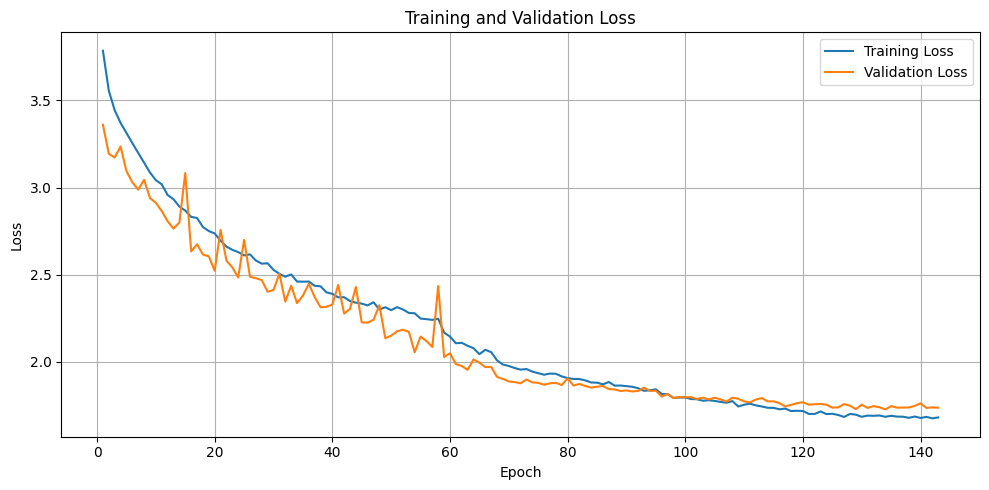

In [25]:
#Plotting train and validation loss
epochs = range(1, len(model.training_losses) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, model.training_losses, label='Training Loss')
plt.plot(epochs, model.validation_losses[3:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

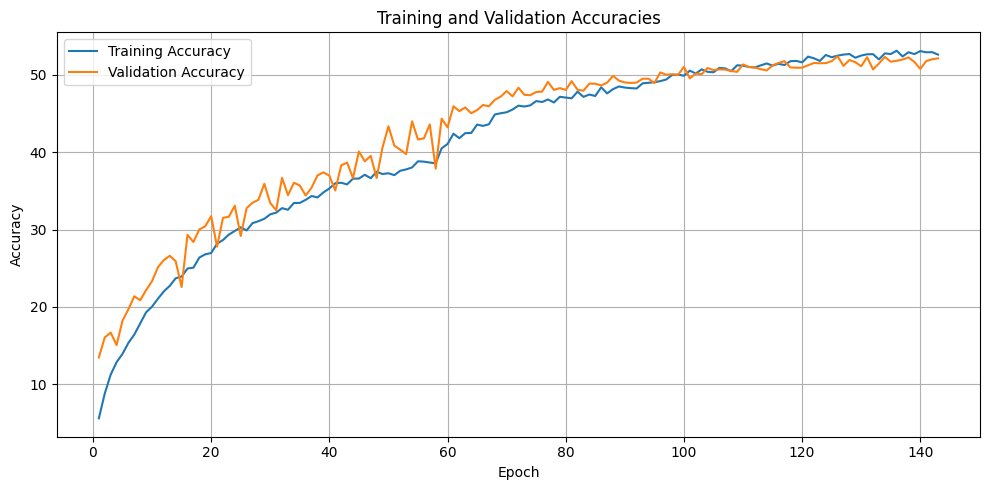

In [26]:
#Plotting train and validation accuracy
epochs = range(1, len(model.training_accuracies) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, [a*100 for a in model.training_accuracies], label='Training Accuracy')
plt.plot(epochs, [a*100 for a in model.validation_accuracies[3:]], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()